# Adopting Geometric Stoichiometry to PISCES

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
ncf_ptrc= "printy_1y_ptrc_Y1832.nc"
ncf_diad= "printy_1y_diad_Y1832.nc"

ptrc= xr.open_dataset(ncf_ptrc)
diad= xr.open_dataset(ncf_diad)

In [3]:
## Parameter from Geometric Stoichiometry
xi  = 0.052   # other basal metabolism
eta = 0.12    # SDA
betaV = 0.64  # protein absorption efficiency
betaH = 0.64  # carbs absorption efficiency
kstarN = 0.9  # max N synthesis efficiency
thetaZ = 5.5  # C:N of zoo
thetaV = 3.7  # C:N of protein
phi    = 0.5  # penalty
fV     = 0.4305 # allocation to protein

## parameter from PISCES
no3rat3 = 0.151     # N:C ratio in zoplankton
epsher= 0.5         # growth efficiency - Can this be max C synthesis efficiency?
epsherN= 0.0755     # epsher*no3rat3
thetaZP = 1/no3rat3 # Zoo C:N ratio from PISCES

In [4]:
# extract zooplankton growth
g_meso= diad['GROZ2'].isel(deptht=1) *86400
g_micr= diad['GROZ1'].isel(deptht=1) *86400

# extract mortalities (for turnover rate?)
mortme= diad['TAUZ2'].isel(deptht=1) *86400
mortmi= diad['TAUZ1'].isel(deptht=1) *86400

**Step 1.**

Calculating the demand for absorbed C for synthesis of growth and replacement biomass (G and $\tau$, respectively) excluding metabolic costs. In PISCES $\tau$ can be modified to the two different mortalities. K$^\star_N$ which is the maximum N synthesis efficiency, can be derived from the growth efficiency ($\epsilon$). 

First we calculate the minimum demand for N from dietary protein DN (molN molN$^{-1}$ d$^{-1}$):

\begin{align}
   DN &= \frac{\tau + G}{K^\star_ N}\\
   \tau &= (m^Z+r^Z)\\
   K^\star_N &= \epsilon \times \theta^{N/C}_{Z\text{P}}
\end{align}


where $m^Z$ and $r^Z$ are the quadratic and linear mortality, respectively, and $\theta^{N/C}_{Z\text{P}}$ is the N:C ratio of zooplankton in PISCES.


The demand for absorbed protein, DV, and extra demand for C to cover the difference between food and zooplankton C:N ratio, DX, are then:
\begin{align}
    DV &= \frac{\theta_V}{\theta_Z} DN\\
    DX &= \frac{(\theta_Z-\theta_V)(\tau+G)}{\theta_Z}
\end{align}

Text(0.5, 1.0, 'extra demand for C micro \n molC molC$^{-1}$ d$^{-1}$')

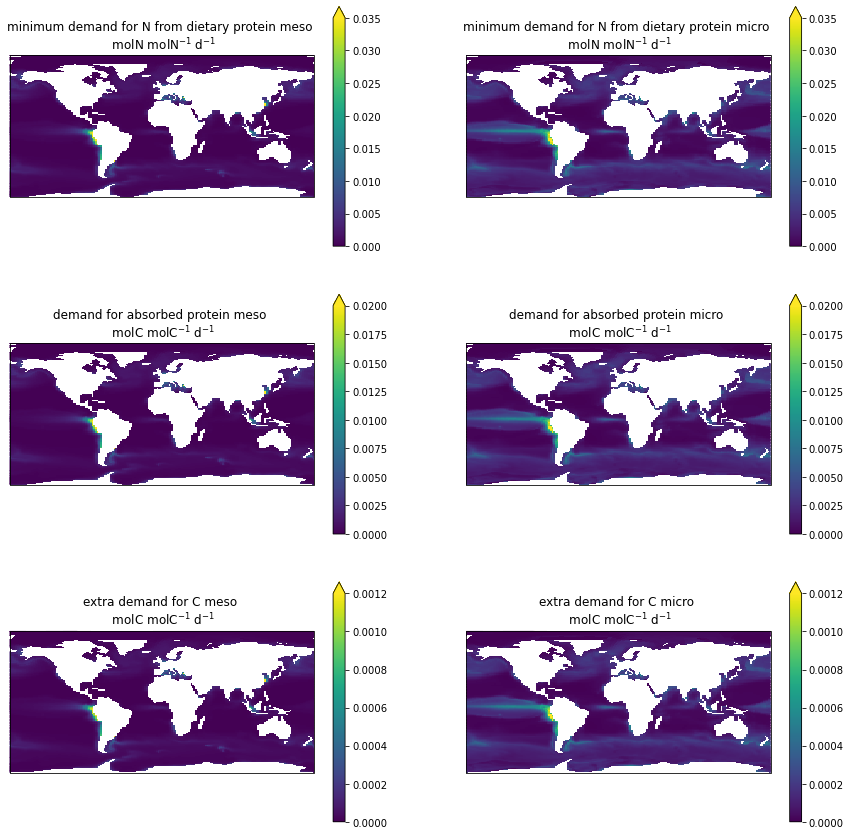

In [5]:
DN_meso= (mortme + g_meso)/(epsher*no3rat3)
DN_micro= (mortmi + g_micr)/(epsher*no3rat3)


DV_meso = (thetaV/thetaZP)* DN_meso
DV_micro = (thetaV/thetaZP)* DN_micro

DX_meso = (thetaZP-thetaV)*(mortme + g_meso)/thetaZP
DX_micro = (thetaZP-thetaV)*(mortmi + g_micr)/thetaZP

fig0=plt.figure(figsize=(15,15))
grid0= plt.GridSpec(3,2)

ax0= fig0.add_subplot(grid0[0, 0], projection= ccrs.PlateCarree())
DN_meso[0,:,:].plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.035, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('minimum demand for N from dietary protein meso \n molN molN$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[0, 1], projection= ccrs.PlateCarree())
DN_micro[0,:,:].plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.035, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('minimum demand for N from dietary protein micro \n molN molN$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[1, 0], projection= ccrs.PlateCarree())
DV_meso[0,:,:].plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.02, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('demand for absorbed protein meso \n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[1, 1], projection= ccrs.PlateCarree())
DV_micro[0,:,:].plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.02, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('demand for absorbed protein micro \n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[2, 0], projection= ccrs.PlateCarree())
DX_meso[0,:,:].plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.0012, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('extra demand for C meso \n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[2, 1], projection= ccrs.PlateCarree())
DX_micro[0,:,:].plot(y='nav_lat', x='nav_lon', vmin=0, vmax= 0.0012, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('extra demand for C micro \n molC molC$^{-1}$ d$^{-1}$')

**Step 2** Calculate cost and penalty.

Energy is required for basal metabolism, $\xi$ (mol C mol C$^{-1}$ d$^{-1}$), and specific dynamic action, (SDA, $\eta$) expressed in as a fixed fraction of the total C intake from protein and carbohydrate (I$_V$+I$_H$, actually calculated in step 3). 

The demand for absorbed C is therefore DX plus the cost of metabolism and SDA:
\begin{equation}
    DA = DX + \xi + \eta(I_V + I_H)
\end{equation}


Either protein or carbohydrate can meet the cost of DA. This is specified using the parameter fv, where fv=0 allocates only carbohydrate to cover the cost DA and fv=1 only uses protein. Ideally the DA is met using carbohydrate, but when protein is used (fv $>$ 0), a metabolic penalty, $\phi$ is given. The C required to meet this cost is partitioned according to fv. The total penalty cost, $\Omega$ is then:
\begin{equation}
    \Omega = DA(\frac{1}{1-\phi fv}-1)
\end{equation}

**Step 3**
Calculate intake of protein (I$_V$) and carbohydrate (I$_H$) before calculating energetic costs and penalty.


Total absorbed protein and carbohydrate are $\beta_V I_V$ and $\beta_H I_H$, respectively, where $\beta_H$ and $\beta_H$ are absorption efficiencies. The allocation of absorbed protein and carbohydrate to growth and metabolism is then:  \begin{align}
\beta_V I_V &= DV + fvDA + fv\Omega \label{IV} \\ 
\beta_H I_H &= (1-fv)DA + (1-fv)\Omega
\end{align}

In PISCES the parameter $\sigma$ is defined as the non-assimilated fraction of ingested prey, which is used to calculate gross growth efficiency and allocates ingested prey to feacal matter. In the Geometric Stoichiometry paper (Anderson et al., 2020) the $\beta$ parameters are the same (0.68) - thus it is possible to use parameter $(1-\sigma)$ as the assimilation efficiency(?). The intake of carbohydrate, is calculated as:
\begin{equation}
    I_H= \frac{
    \frac{DV + a(DX+\xi)}{\beta_V - \eta a} + \frac{DX + \xi}{\eta} } {\frac{\beta_H(1-fv\phi)}{\eta(1-fv)}-\frac{\eta a}{\beta_V- \eta a}-1}, a = \frac{fv}{(1-\phi fv)}, fv < 1
\end{equation}

and the intake of protein:
\begin{equation}
   I_V= \frac{\beta_H I_H (1-\phi fv)}{\eta(1-fv)} - \frac{DX+\xi}{\eta} - I_H, fv < 1
\end{equation}


Text(0.5, 1.0, 'Ingested Protein \n molC molC$^{-1}$ d$^{-1}$')

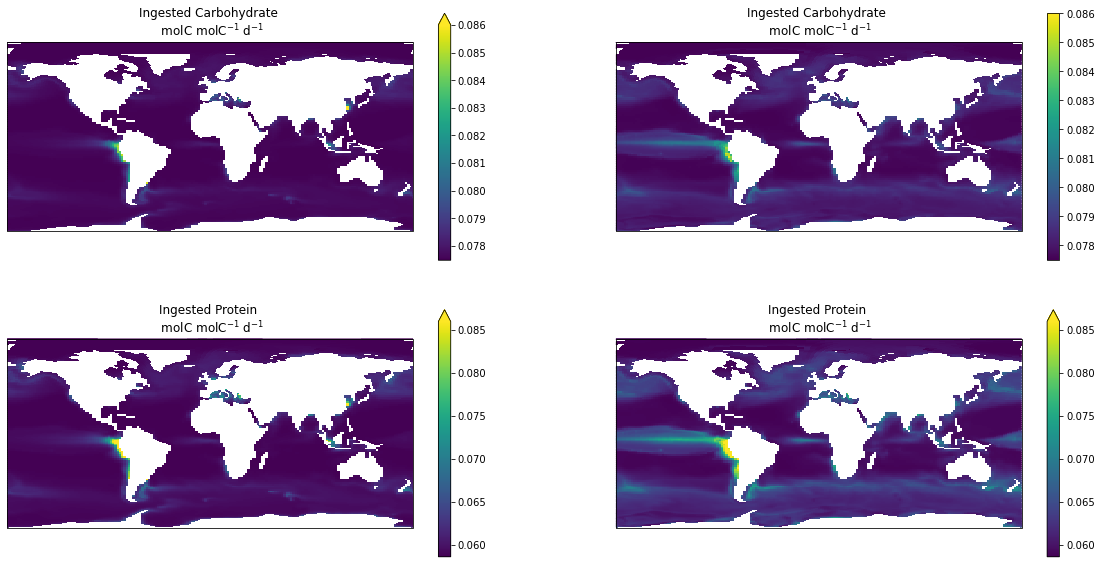

In [6]:
a= fV/(1-(phi*fV))

# for meso first
numer = ( DV_meso + a*(DX_meso + xi))/(betaV -(eta * a)) + ((DX_meso + xi)/eta)
denom = ( (betaH *(1-(phi*fV))) / (eta * (1-fV)) ) - ((eta*a)/(betaV-(eta*a))) -1
IH_meso = numer/denom
IV_meso = betaH*IH_meso*(1-(phi*fV)) / (eta*(1-fV)) - ((DX_meso + xi)/eta) - IH_meso

# for micro first
numer = ( DV_micro + a*(DX_micro + xi))/(betaV -(eta * a)) + (DX_micro + xi)/eta
denom = ( (betaH *(1-(phi*fV))) / (eta * (1-fV)) ) - ((eta*a)/(betaV-(eta*a))) -1
IH_micro = numer/denom
IV_micro = betaH*IH_micro*(1-(phi*fV)) / (eta*(1-fV)) - ((DX_micro + xi)/eta) - IH_micro

fig0=plt.figure(figsize=(20,10))
grid0= plt.GridSpec(2,2)

ax0= fig0.add_subplot(grid0[0, 0], projection= ccrs.PlateCarree())
IH_meso[0,:,:].plot(y='nav_lat', x='nav_lon',  vmax=0.086, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Ingested Carbohydrate \n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[0, 1], projection= ccrs.PlateCarree())
IH_micro[0,:,:].plot(y='nav_lat', x='nav_lon',  vmax=0.086,transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Ingested Carbohydrate \n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[1, 0], projection= ccrs.PlateCarree())
IV_meso[0,:,:].plot(y='nav_lat', x='nav_lon',  vmax=0.086, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Ingested Protein \n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[1, 1], projection= ccrs.PlateCarree())
IV_micro[0,:,:].plot(y='nav_lat', x='nav_lon',  vmax=0.086,transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Ingested Protein \n molC molC$^{-1}$ d$^{-1}$')


Text(0.5, 1.0, 'Total Cost micro\n molC molC$^{-1}$ d$^{-1}$')

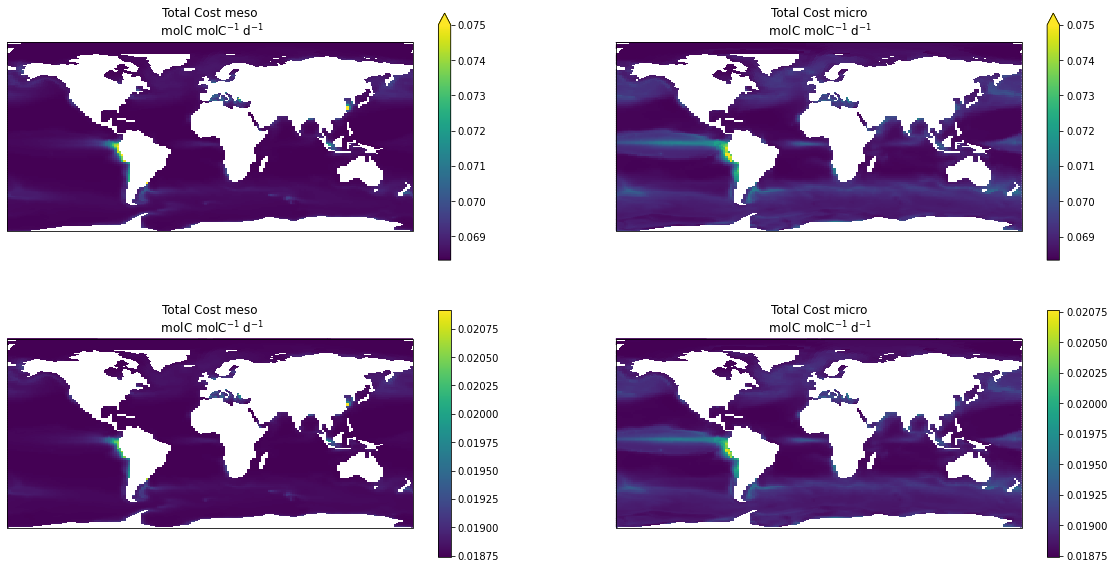

In [7]:
DA_meso = DX_meso + xi + eta*(IV_meso+IH_meso)
DA_micro = DX_micro + xi + eta*(IV_micro+IH_micro)

# total penalty
if phi > 0:
    omega_meso = DA_meso * (1/(1-(phi*fV))-1)
    omega_micro = DA_micro * (1/(1-(phi*fV))-1)
else:
    omega_meso = 0
    omega_micro = 0

fig0=plt.figure(figsize=(20,10))
grid0= plt.GridSpec(2,2)

ax0= fig0.add_subplot(grid0[0, 0], projection= ccrs.PlateCarree())
DA_meso[0,:,:].plot(y='nav_lat', x='nav_lon', vmax=0.075, transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Total Cost meso\n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[0, 1], projection= ccrs.PlateCarree())
DA_micro[0,:,:].plot(y='nav_lat', x='nav_lon', vmax=0.075,transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Total Cost micro\n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[1, 0], projection= ccrs.PlateCarree())
omega_meso[0,:,:].plot(y='nav_lat', x='nav_lon', transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Total Cost meso\n molC molC$^{-1}$ d$^{-1}$')

ax0= fig0.add_subplot(grid0[1, 1], projection= ccrs.PlateCarree())
omega_micro[0,:,:].plot(y='nav_lat', x='nav_lon', transform=ccrs.PlateCarree(), ax=ax0, add_labels=False, add_colorbar=True)
ax0.set_title('Total Cost micro\n molC molC$^{-1}$ d$^{-1}$')
